# CSI4142 - Fundamentals of Data Science Assignment 2  

## *Data Cleaning*  

**Professor**: Caroline Barrière  
**Students**: Mohamed-Obay Alshaer & Samih Karroum  
**Student Numbers**: 300170489 & 300188957  
**Submission Date**: February 25th, 2025  
**Group Number**: 39  

---  

## Assignment Overview  

This notebook implements a **Clean Data Checker**, designed to validate the integrity and quality of a dataset by identifying common data issues. The checker performs **10 different validation tests**, each targeting a specific type of potential error:  

1. **Data Type Errors** – Ensuring values match their expected data types.  
2. **Range Errors** – Checking if numerical values fall within an expected range.  
3. **Format Errors** – Validating that data follows a specific format (e.g., dates, IDs).  
4. **Consistency Errors** – Identifying conflicting or contradictory values.  
5. **Uniqueness Errors** – Verifying attributes that should have unique values.  
6. **Presence Errors** – Detecting missing values in required fields.  
7. **Length Errors** – Checking if text values meet length constraints.  
8. **Look-up Errors** – Ensuring categorical values exist in a predefined list.  
9. **Exact Duplicate Errors** – Detecting completely duplicated rows.  
10. **Near Duplicate Errors** – Identifying rows that are very similar but not identical.  

Each test is structured into **four parts**:  

1. **Error Description** – Explanation of the type of error being checked.  
2. **Parameter Definition** – A cell where users can define validation rules.  
3. **Validation Code** – The logic that performs the check based on provided parameters.  
4. **Results Report** – A summary of detected issues with examples.  

---  

## Dataset Description  

The dataset used in this notebook contains **records of real estate transactions in New York City** over a **12-month period**. Each row represents a **building or building unit sale** and includes information such as location, address, property type, sale price, and sale date.  

### **Key Fields**  
- **BOROUGH** – Encoded as a digit (1–5) representing different NYC boroughs.  
- **BLOCK, LOT** – Together with BOROUGH, these form a unique property identifier.  
- **BUILDING CLASS AT PRESENT / TIME OF SALE** – Indicates the type of property.  
- **SALE PRICE** – The transaction amount for the property.  
- **SALE DATE** – The date when the property was sold.  

### **Important Considerations**  
- Some sales have **$0 or very low values**, which often indicate **property transfers** rather than standard sales.  
- Sales data follows **financial definitions**, meaning some records represent **entire buildings**, while others represent **individual apartments**.  

This dataset provides **valuable insight into NYC's real estate market trends**, and by running the **Clean Data Checker**, we can identify and correct **potential data quality issues** before further analysis.  


In [12]:
!pip install fuzzywuzzy


In [13]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
import warnings
warnings.filterwarnings('ignore')

In [14]:
df = pd.read_csv('./nyc-rolling-sales.csv', index_col=0)

df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [15]:
# Check the basic shape and information about the dataset
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("\nColumn names:")
for col in df.columns:
    print(f"- {col}")

Number of rows: 84548
Number of columns: 21

Column names:
- BOROUGH
- NEIGHBORHOOD
- BUILDING CLASS CATEGORY
- TAX CLASS AT PRESENT
- BLOCK
- LOT
- EASE-MENT
- BUILDING CLASS AT PRESENT
- ADDRESS
- APARTMENT NUMBER
- ZIP CODE
- RESIDENTIAL UNITS
- COMMERCIAL UNITS
- TOTAL UNITS
- LAND SQUARE FEET
- GROSS SQUARE FEET
- YEAR BUILT
- TAX CLASS AT TIME OF SALE
- BUILDING CLASS AT TIME OF SALE
- SALE PRICE
- SALE DATE


In [16]:
print("\nData types:")
print(df.dtypes)


Data types:
BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
LOT                                int64
EASE-MENT                         object
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object


### Test 1: Data Type Errors
**Description:**  
This test verifies that the values in specific attributes match their expected data types (e.g., numeric, string, date). For example, the `BOROUGH` and `SALE PRICE` should be numeric while `ADDRESS` should be a string.

In [26]:
# List all columns to check
columns_to_check = {
    'BOROUGH': 'integer',
    'BLOCK': 'integer',
    'LOT': 'integer',
    'SALE PRICE': 'integer',
    'SALE DATE': 'date',
    'BUILDING CLASS CATEGORY': 'string',
    'TAX CLASS AT PRESENT': 'string',
    'NEIGHBORHOOD': 'string'
}


date_formats = ['%m/%d/%Y', '%Y-%m-%d %H:%M:%S']

In [27]:
def check_data_types(df, columns_to_check, date_format):
    """
    Check if columns in the dataframe have the expected data types.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to check
    columns_to_check : dict
        Dictionary with column names as keys and expected data types as values
    date_format : str
        The expected format for date columns
        
    Returns:
    --------
    dict
        A dictionary with column names as keys and lists of problematic rows as values
    """
    errors = {}
    
    for column, expected_type in columns_to_check.items():
        if column not in df.columns:
            print(f"Warning: Column '{column}' not found in the dataframe.")
            continue
            
        error_rows = []
        
        if expected_type == 'integer':
            # Check if values can be converted to integers
            for idx, value in enumerate(df[column]):
                if pd.isna(value):
                    continue
                try:
                    int(value)
                except (ValueError, TypeError):
                    error_rows.append((idx, value))
                    
        elif expected_type == 'float':
            # Check if values can be converted to floats
            for idx, value in enumerate(df[column]):
                if pd.isna(value):
                    continue
                try:
                    # Remove currency symbol and commas if present
                    if isinstance(value, str):
                        value = value.replace('$', '').replace(',', '')
                    float(value)
                except (ValueError, TypeError):
                    error_rows.append((idx, value))
                    
        elif expected_type == 'date':
            # Check if values match any of the accepted date formats
            for idx, value in enumerate(df[column]):
                if pd.isna(value):
                    continue
                valid_date = False
                for format in date_formats:
                    try:
                        if isinstance(value, str):
                            datetime.strptime(value, format)
                            valid_date = True
                            break
                    except ValueError:
                        continue
                if not valid_date:
                    error_rows.append((idx, value))
                    
        elif expected_type == 'string':
            # Check if values are strings
            for idx, value in enumerate(df[column]):
                if pd.isna(value):
                    continue
                if not isinstance(value, str):
                    error_rows.append((idx, value))
        
        if error_rows:
            errors[column] = error_rows
            
    return errors

# Run the checker
data_type_errors = check_data_types(df, columns_to_check, date_format)

### Report of Findings

Data Type Error Report:
--------------------------------------------------

Column 'SALE PRICE' (expected type: integer):
Found 14561 data type errors.
Examples:
  - Row 2: ' -  '
  - Row 3: ' -  '
  - Row 6: ' -  '
  - Row 8: ' -  '
  - Row 9: ' -  '
  - ... and 14556 more errors.


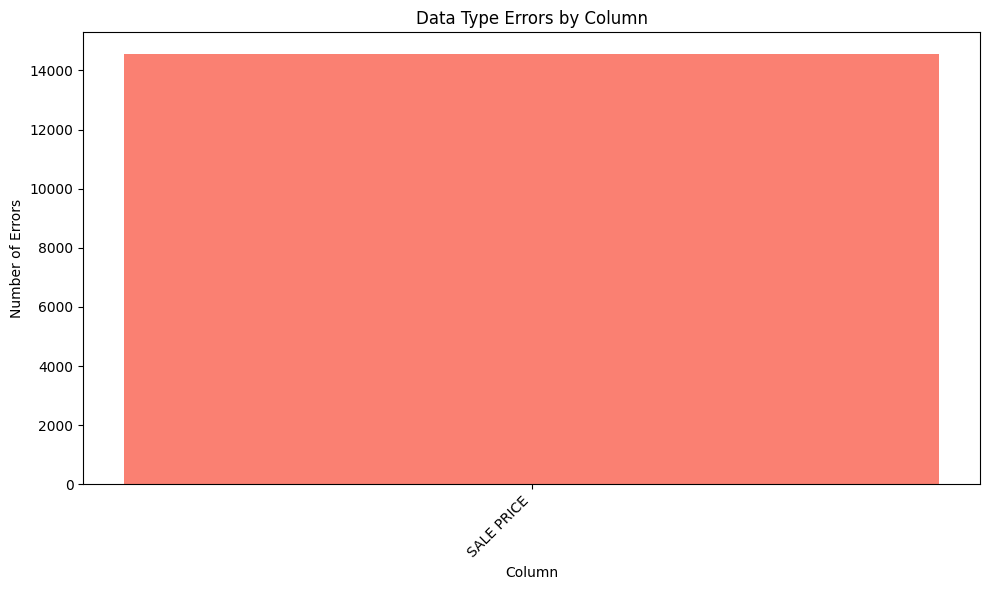

In [28]:
# Generate report
print("Data Type Error Report:")
print("-" * 50)

if not data_type_errors:
    print("No data type errors found.")
else:
    for column, errors in data_type_errors.items():
        expected_type = columns_to_check[column]
        print(f"\nColumn '{column}' (expected type: {expected_type}):")
        print(f"Found {len(errors)} data type errors.")
        print("Examples:")
        for i, (idx, value) in enumerate(errors[:5]):  # Show first 5 examples
            print(f"  - Row {idx+1}: '{value}'")
        if len(errors) > 5:
            print(f"  - ... and {len(errors)-5} more errors.")
            
    # Create a bar chart of error counts
    error_counts = {column: len(errors) for column, errors in data_type_errors.items()}
    plt.figure(figsize=(10, 6))
    plt.bar(error_counts.keys(), error_counts.values(), color='salmon')
    plt.title('Data Type Errors by Column')
    plt.xlabel('Column')
    plt.ylabel('Number of Errors')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Test 2: Range Errors
**Description:**  
This test verifies that numerical values fall within an acceptable range. For instance, the `SALE PRICE` should be between a defined minimum and maximum.

### Test 3: Format Errors
**Description:**  
This test validates that data follows a specified format. For example, the `SALE DATE` should follow the format `YYYY-MM-DD` and the `ADDRESS` should match a certain pattern.

### Test 4: Consistency Errors
**Description:**  
This test checks for conflicting or contradictory values. For instance, if the `BOROUGH` code does not align with known NYC boroughs or if related fields such as `BLOCK` and `LOT` are inconsistent.
